# 日本ガイシ 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '5333.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='3mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-23 00:00:00+09:00,1966.5,1970.0,1948.0,1965.5,564800,0.0,0.0
2024-12-24 00:00:00+09:00,1973.0,1975.0,1961.0,1961.0,290800,0.0,0.0
2024-12-25 00:00:00+09:00,1965.0,1973.0,1946.0,1968.0,552400,0.0,0.0
2024-12-26 00:00:00+09:00,1968.0,2000.0,1960.0,2000.0,548100,0.0,0.0
2024-12-27 00:00:00+09:00,2005.0,2024.0,1996.5,2022.5,698200,0.0,0.0
2024-12-30 00:00:00+09:00,2027.0,2029.0,2004.5,2013.0,738000,0.0,0.0
2025-01-06 00:00:00+09:00,2001.0,2010.0,1979.5,1988.0,796500,0.0,0.0
2025-01-07 00:00:00+09:00,1988.5,1993.0,1966.0,1985.0,619000,0.0,0.0
2025-01-08 00:00:00+09:00,1970.0,1993.5,1967.0,1981.0,518500,0.0,0.0


## 日足チャートとパラボリック SAR

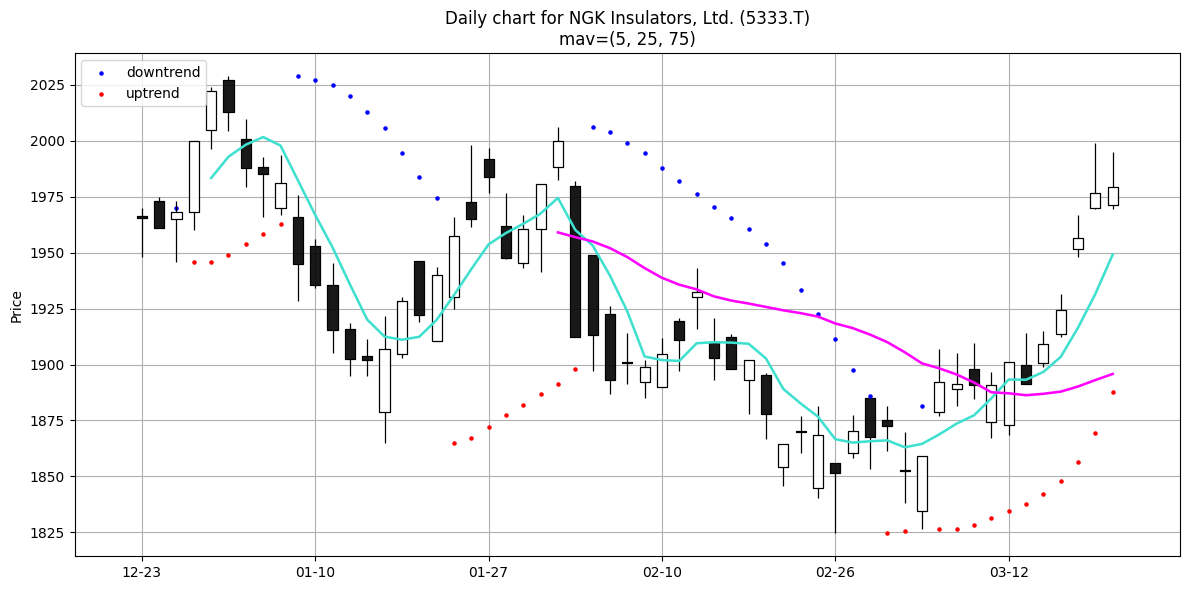

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-19 00:00:00+09:00    1976.5
2025-03-21 00:00:00+09:00    1979.5
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-19 00:00:00+09:00    NaN
2025-03-21 00:00:00+09:00    3.0
Name: Close, dtype: float64